In [238]:
import pandas as pandas
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

file_path = ('../data/attrition_data.csv')
df = pandas.read_csv(file_path)

# Define features and target variable
features = [
    "Age",
    "DistanceFromHome",
    "Education",
    "EnvironmentSatisfaction",
    "HourlyRate",
    "JobInvolvement",
    "JobLevel",
    "JobSatisfaction",
    "MaritalStatus",
    "NumCompaniesWorked",
    "OverTime",
    "PercentSalaryHike",
    "PerformanceRating",
    "StockOptionLevel",
    "TotalWorkingYears",
    "WorkLifeBalance",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager"
]

# Convert strings into numerical values
df['Attrition'] = df['Attrition'].astype('category').cat.codes

df['OverTime'] = df['OverTime'].astype('category').cat.codes
df['MaritalStatus'] = df['MaritalStatus'].astype('category').cat.codes

# Assign variables
y = df['Attrition']
X = df[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(train_X, train_y)

val_predictions = model.predict(val_X)
print("Accuracy:", accuracy_score(val_y, val_predictions))

Accuracy: 0.842391304347826


In [227]:
import lightgbm as lgb

# Split data
train_X, val_X, train_y, val_y = train_test_split(X, y, stratify=y, random_state=42)

# Create LightGBM datasets
train_data = lgb.Dataset(train_X, label=train_y)
val_data = lgb.Dataset(val_X, label=val_y, reference=train_data)

# Set parameters (binary classification)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,  # handles class imbalance
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'seed': 42,
}

# Train
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(10)
    ]
)

# Predict
val_preds_prob = model.predict(val_X, num_iteration=model.best_iteration)
val_preds = (val_preds_prob >= 0.5).astype(int)

# Evaluate
accuracy = accuracy_score(val_y, val_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

TypeError: train() got an unexpected keyword argument 'verbose_eval'

Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}
Best F1 score: 0.4995806228064293
OverTime                   0.113633
TotalWorkingYears          0.102816
Age                        0.102023
YearsAtCompany             0.089459
YearsWithCurrManager       0.087671
StockOptionLevel           0.070388
NumCompaniesWorked         0.050775
DistanceFromHome           0.048377
HourlyRate                 0.047334
EnvironmentSatisfaction    0.043995
MaritalStatus              0.039957
JobLevel                   0.038171
YearsInCurrentRole         0.037952
JobSatisfaction            0.037302
WorkLifeBalance            0.033844
JobInvolvement             0.029553
PercentSalaryHike          0.026749
dtype: float64


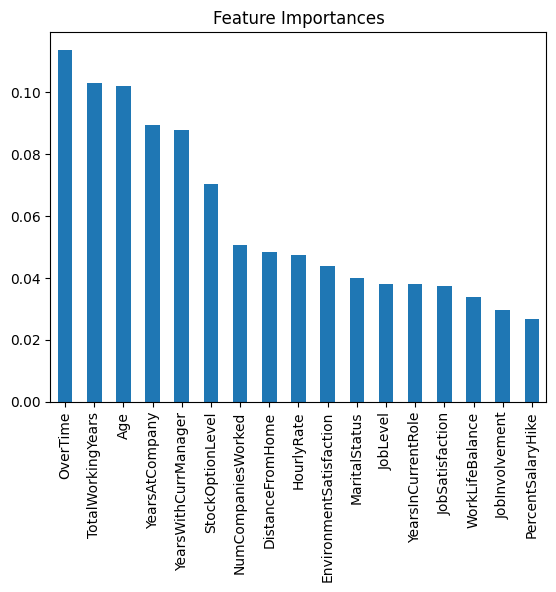

In [190]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    model, param_dist, n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1
)
search.fit(train_X, train_y)

print("Best params:", search.best_params_)
print("Best F1 score:", search.best_score_)

importances = search.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_imp)

# Plot
feat_imp.plot(kind='bar')
plt.title("Feature Importances")
plt.show()